In [4]:
# 1. Design a function to compute Euclidean and Mahalanobis distance for all data. 
import numpy as np

# 0~5 / total:6
dataset = [[170, 50.5, 29, 80], 
           [172, 71.1, 33, 93],  
           [167, 61.3, 37, 72], 
           [180, 88.4, 44, 88], 
           [188, 69.8, 46, 85], 
           [162, 58.2, 35, 69]] 
dataset = np.array(dataset)

In [7]:
# Euclidean distance
dataset_size = len(dataset)
Edistances = np.zeros(dataset_size)
mean = np.mean(dataset, axis=0)
for i in range(len(dataset)):
    Edistances[i] = np.sqrt( np.sum( (dataset[i] - mean)**2 ) )
np.round_( Edistances,1)

array([18.4, 13.4, 12.2, 24.8, 17.9, 18.7])

In [10]:
# Mahalanobis distance
cov_size = len(dataset.T)
cov= np.zeros((cov_size,cov_size))

for i in range(cov_size):
    for j in range(cov_size):
        cov[i,j] = np.sum( (dataset.T[i]-np.mean(dataset.T[i]))* (dataset.T[j]-np.mean(dataset.T[j]) ) ) \
                                        /   (np.sum( np.count_nonzero(dataset.T[i]*dataset.T[j])) )                   
Mdistances = np.zeros(dataset_size)
for i in range(distance_size):
    Mdistances[i] = np.sqrt( (dataset[i]-mean).T @ np.linalg.inv(cov) @ (dataset[i]-mean) )
        
np.round_( Mdistances,1)            

array([2.2, 2.2, 1.1, 2.2, 2.2, 1.7])

In [1]:
# 2. For the detected corners by Harris method, find the key descriptor of SIFT as below.
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math

img = Image.open('Image/lena.bmp').convert('L')
img = np.array(img)

In [2]:
def filtering(img, filter):   # convolution
    h, w = img.shape
    fSize = len(filter)       # filter Size
    pSize = (fSize-1) // 2    # padding Size
    
    img = np.pad(img, ((pSize,pSize),(pSize,pSize)), 'constant', constant_values=0)
    filteredImg = np.zeros((h,w))
    
    for i in range(pSize,h+pSize):      # operate on ground-truth pixel
        for j in range(pSize,w+pSize):
            product = img[i-pSize:i+pSize+1,j-pSize:j+pSize+1] * filter
            filteredImg[i-pSize][j-pSize] = product.sum()
            
    return filteredImg

def gaussianFilter(size, std):
    filter = np.ones((size,size))
    filterOffset = size // 2
    for i in range(size):
        for j in range(size):
            filter[i][j] = math.exp( -1 * ( (i-filterOffset)**2 + (j-filterOffset)**2 ) / (2*(std**2)) )
    return filter / filter.sum()

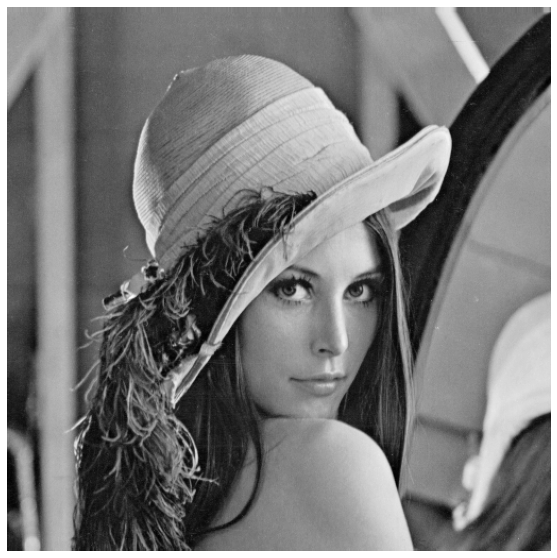

In [25]:
# 2. For the detected corners by Harris method, find the key descriptor of SIFT as below.
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math

img = Image.open('Image/lena.bmp').convert('L')
img = np.array(img)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img, 'gray')

In [26]:
def filtering(img, kernel):   # convolution
    h, w = img.shape
    fSize = len(kernel)       # filter Size
    pSize = (fSize-1) // 2    # padding Size
    
    img = np.pad(img, ((pSize,pSize),(pSize,pSize)), 'symmetric')
    filteredImg = np.zeros((h,w))
    
    for i in range(pSize,h+pSize):      # operate on ground-truth pixel
        for j in range(pSize,w+pSize):
            product = img[i-pSize:i+pSize+1,j-pSize:j+pSize+1] * kernel
            filteredImg[i-pSize][j-pSize] = product.sum()
            
    return filteredImg

def gaussianFilter(size, std):
    kernel = np.ones((size,size))
    filterOffset = size // 2
    for i in range(size):
        for j in range(size):
            kernel[i][j] = math.exp( -1 * ( (i-filterOffset)**2 + (j-filterOffset)**2 ) / (2*(std**2)) )
    return kernel / kernel.sum()

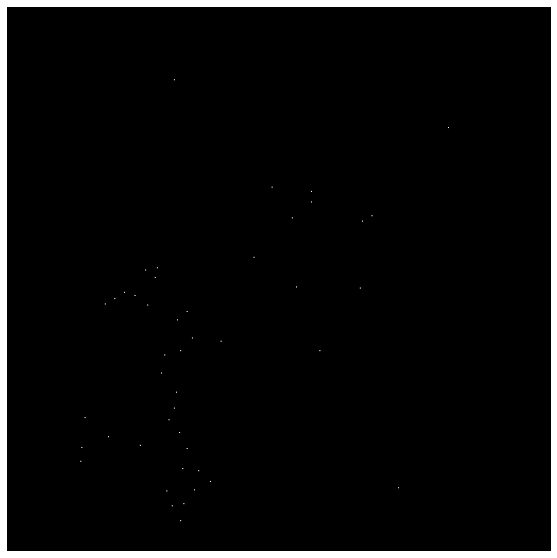

In [27]:
def suppression(img, mask_size):
    h,w = img.shape
    for i in range(h-mask_size+1):
        for j in range(w-mask_size+1):
            temp = img[i:i+mask_size,j:j+mask_size].copy()
            idx = np.argmax(temp)
            temp = np.zeros((mask_size,mask_size))
            temp[idx//mask_size,idx%mask_size] = 1
            img[i:i+mask_size,j:j+mask_size] = img[i:i+mask_size,j:j+mask_size]  * temp
            
    return img
            
def Harris(img, k, thresh):
    h,w = img.shape
    mx = np.array( [ [-1,0,1], [-1,0,1], [-1,0,1] ])
    my = np.array( [ [-1,-1,-1], [ 0, 0, 0], [ 1, 1, 1] ])
    Gaussian_kernel = gaussianFilter(3,3)
    
    Ix = filtering(img,mx)
    Iy = filtering(img,my)
    Ixx = Ix*Ix
    Iyy = Iy*Iy
    Ixy = Ix*Iy
    
    Ixx = filtering(Ixx, Gaussian_kernel)
    Iyy = filtering(Iyy, Gaussian_kernel)
    Ixy = filtering(Ixy, Gaussian_kernel)
    
    det = (Ixx * Iyy) - (Ixy*Ixy)
    trace = Ixx + Iyy
    r = det - k*(trace**2)
    cv2.normalize(r,r,0.0,1.0,cv2.NORM_MINMAX)

    #nonMaximumSuppression
    r= suppression(r,9)
    
    cornermap = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            if r[i,j] > thresh:
                cornermap[i,j] = 255
    
    return cornermap

corner_map = Harris(img, 0.05, 0.5)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(corner_map, 'gray')

[[ 68.    157.     -0.128]
 [113.    415.     -2.642]
 [169.    249.     -0.757]
 [173.    286.     -0.757]
 [183.    286.      1.128]
 [196.    343.     -2.013]
 [198.    268.      0.5  ]
 [201.    334.     -2.642]
 [235.    232.      2.385]
 [245.    141.     -0.757]
 [247.    130.     -2.642]
 [254.    139.      3.013]
 [263.    272.      0.5  ]
 [264.    332.     -0.128]
 [268.    110.     -2.013]
 [271.    120.     -2.013]
 [274.    101.     -0.757]
 [279.     92.      2.385]
 [280.    132.      1.757]
 [286.    169.     -2.642]
 [294.    160.     -2.642]
 [311.    174.     -0.757]
 [314.    201.     -2.642]
 [323.    163.      3.013]
 [323.    294.      3.013]
 [327.    148.      3.013]
 [344.    145.      2.385]
 [362.    159.     -2.013]
 [377.    157.     -0.128]
 [386.     73.     -2.642]
 [388.    152.     -0.757]
 [400.    162.      3.013]
 [404.     95.      3.013]
 [412.    125.     -0.757]
 [414.     70.      3.013]
 [415.    169.     -0.757]
 [427.     69.     -2.642]
 

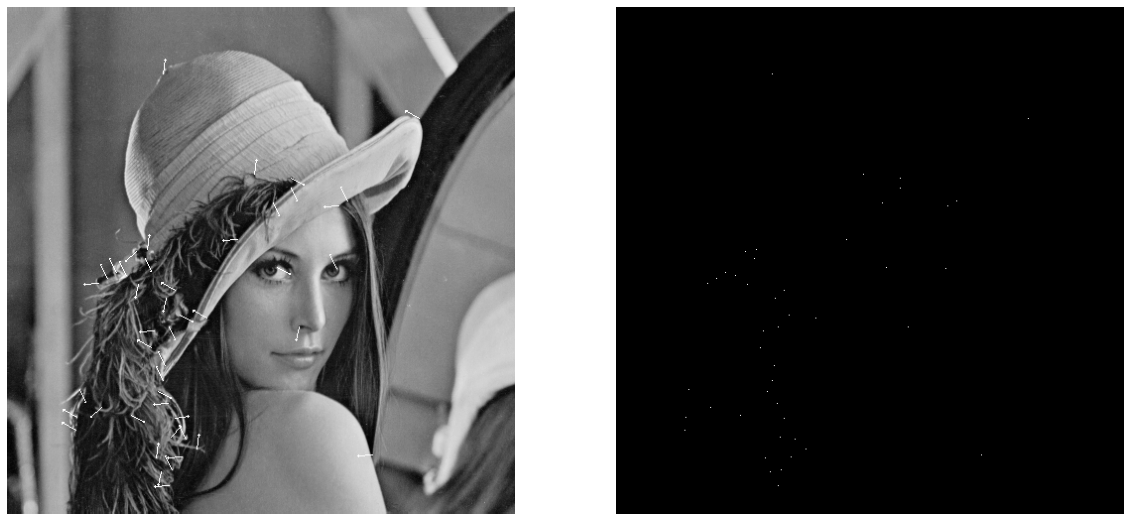

In [35]:
def descripter(img, corner_map):
    index = np.nonzero(corner_map)
    orientation = []
    Gaussian_kernel = gaussianFilter(3,3)
    img = filtering(img, Gaussian_kernel)
    
    for i in range(len(index[0])):
        # coner map index 추출
        y = index[0][i]
        x = index[1][i]
        
        magnitude = np.zeros((16,16))
        direction = np.zeros((16,16))
        # 16x16 matrix 생성
        for i in range(-7,9):  # y
            for j in range(-7,9): #x
                temp_y = y+j
                temp_x = x+j
                magnitude[i+7,j+7] = (img[temp_y,temp_x+1] - img[temp_y,temp_x-1])**2 + \
                                                                                (img[temp_y+1,temp_x] - img[temp_y-1,temp_x])**2
                direction[i+7,j+7] = np.arctan2( (img[temp_y+1,temp_x] - img[temp_y-1,temp_x]), \
                                                                                (img[temp_y,temp_x+1] - img[temp_y,temp_x-1]))
        # histogram 생성
        bins = 10
        width = ( np.pi * 2 ) / bins
        temp_mag = magnitude.ravel()
        # histogram index 계산
        temp_direction = direction//width + bins//2
        temp_direction = temp_direction.ravel().astype('int')
        
        # hitogram index위치에 동일한 위치의 magnitude 더함
        histogram = np.zeros(bins)
        for i in range( len(temp_direction) ):
            histogram[temp_direction[i]] += temp_mag[i]
        
        # histogram argmax를 통해 orientation 도출
        n = np.argmax(histogram) - bins//2
        ot = np.round_( (width * n + (width * n+1))/2 , 3)
        # y,x, orientation 꼴으로 저장
        orientation.append([y,x,ot])
    return np.array(orientation)

np.set_printoptions(precision=3, suppress=True)
orientation = descripter(img, corner_map)
print(orientation)
for temp in orientaion:
    y,x = temp[0], temp[1]
    dx, dy = 15*np.cos(temp[2]), 15*np.sin(temp[2])
    cv2.arrowedLine(img, (int(x), int(y)), (int(x+dx), int(y+dy)), (255,0,0))
    

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(corner_map, 'gray')